#Housekeeping

Load datasets / Installs and imports

In [1]:
%%capture
!pip install pyirr
!pip install wget

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np
from pyirr import kappam_fleiss
from scipy.stats import ttest_ind, mannwhitneyu, f_oneway
import wget

In [3]:
wget.download("https://raw.githubusercontent.com/paulhimstedt/data_aug_irony/main/results/classifier_metrics.csv")
wget.download("https://raw.githubusercontent.com/paulhimstedt/data_aug_irony/main/results/survey_results.csv")
df = pd.read_csv("classifier_metrics.csv")
df_survey = pd.read_csv("survey_results.csv")

## Data preprocessing

Create Data frames containing the answers regarding Sarcasm and Origin

In [4]:
df_cleaned = df_survey.iloc[1:, 1:]
df_answers = df_cleaned.iloc[::2, :]
df_machine_info = df_cleaned.iloc[1::2, :]

Process Survey data and remove unnecessary data

In [5]:
# DataFrame for answers to the sarcasm question
df_survey = df_survey.head(84)
df_sarcasm = pd.DataFrame({
    'Ground Truth': df_answers.iloc[:, 0],
    'Tweet Number': df_answers.iloc[:, 2],
    'TEXT': df_answers['TEXT'],
    'Annotator 1': df_answers.iloc[:, -5],
    'Annotator 2': df_answers.iloc[:, -4],
    'Annotator 3': df_answers.iloc[:, -3],
    'Annotator 4': df_answers.iloc[:, -2],
    'Annotator 5': df_answers.iloc[:, -1]
})
df_sarcasm = df_sarcasm.iloc[:-2, :]
df_sarcasm = df_sarcasm.reset_index(drop=True)
df_sarcasm =df_sarcasm.head(40)
# DataFrame for machine information
df_machine = pd.DataFrame({
    'Ground Truth': df_machine_info.iloc[:, 1],
    'Tweet Number': df_machine_info.iloc[:, 2],
    'TEXT': df_machine_info['TEXT'],
    'Annotator 1': df_machine_info.iloc[:, -5],
    'Annotator 2': df_machine_info.iloc[:, -4],
    'Annotator 3': df_machine_info.iloc[:, -3],
    'Annotator 4': df_machine_info.iloc[:, -2],
    'Annotator 5': df_machine_info.iloc[:, -1]
})
df_machine = df_machine.iloc[:-1, :]
df_machine = df_machine.reset_index(drop=True)
df_machine = df_machine.head(40)

remove the average collumns

In [6]:
def split_dataframe(df, selected_columns):
    selected_columns = list(selected_columns)
    invalid_columns = set(selected_columns) - set(df.columns)
    if invalid_columns:
        raise ValueError(f"Invalid column names: {invalid_columns}")
    # Create DataFrame with selected columns
    selected_df = df[selected_columns]
    # Create DataFrame with the rest of the columns
    rest_df = df.drop(columns=selected_columns)
    return selected_df, rest_df

selected_columns = ['average 1 percent augmentation                                        ', 'average 5 percent augmentation', 'average run5 10 percent augmentation', 'average 25 percent augmentation', 'average 50 percent augmentation (weighted)']
#remove the average collumn
selected_df, rest_df = split_dataframe(df, selected_columns)
#Display the collumns removed
selected_df.head(10)#, rest_df.head()

,average 1 percent augmentation,average 5 percent augmentation,average run5 10 percent augmentation,average 25 percent augmentation,average 50 percent augmentation (weighted)
0,0.726420,0.757140,0.733440,0.735980,0.738720
1,1.348980,1.181520,1.176720,1.265700,1.249780
2,0.494760,0.487760,0.518960,0.492000,0.492100
3,0.754080,0.756680,0.761020,0.756720,0.757180
4,0.716160,0.757140,0.733440,0.735980,0.738720
5,0.731960,0.756420,0.746060,0.744120,0.747400
6,0.803660,0.858480,0.821820,0.830000,0.832840
7,0.829163,0.858357,0.840894,0.843496,0.845302
8,0.161249,0.149149,0.178697,0.156934,0.159853
9,0.495206,0.503753,0.509795,0.500215,0.502577


split by experiments

In [7]:
df = rest_df
experiments = ['baseline', 'weighted_baseline', 'augmented_gpt2', 'augmented_gpt3', 'augmented_gpt_mixed']
experiment_dfs = {}

# Split the original into smaller dfs
for i, experiment in enumerate(experiments):
    start_index = i * 16
    end_index = (i + 1) * 16
    experiment_dfs[experiment] = df.iloc[start_index:end_index].reset_index(drop=True)

baseline_df = experiment_dfs['baseline']
weighted_baseline_df = experiment_dfs['weighted_baseline']
augmented_gpt2_df = experiment_dfs['augmented_gpt2']
augmented_gpt3_df = experiment_dfs['augmented_gpt3']
augmented_gpt_mixed_df = experiment_dfs['augmented_gpt_mixed']

baseline_df.head(16)

,Unnamed: 0,run1 1 percent augmentation,run2 1 percent augmentation,run3 1 percent augmentation,run4 1 percent augmentation,run5 1 percent augmentation,run1 5 percent augmentation,run2 5 percent augmentation,run3 5 percent augmentation,run4 5 percent augmentation,...,run2 25 percent augmentation,run3 25 percent augmentation,run4 25 percent augmentation,run5 25 percent augmentation,run1 50 percent augmentation (weighted),run2 50 percent augmentation (weighted),run3 50 percent augmentation (weighted),run4 50 percent augmentation (weighted),run5 50 percent augmentation (weighted),BASELINE_AVERAGES
0,baseline Accuracy,0.702900,0.857000,0.707900,0.690700,0.673600,0.733600,0.760000,0.742900,0.792100,...,0.821400,0.719300,0.730700,0.717100,0.727900,0.768600,0.752100,0.760000,0.685000,0.738340
1,baseline Log-loss,1.743300,0.907700,1.240100,1.340500,1.513300,1.301800,1.120900,1.194600,1.201700,...,1.006700,1.171700,1.469700,1.201800,1.371000,1.044800,1.222300,1.030300,1.580500,1.244540
2,baseline AUC-ROC,0.488800,0.510900,0.523000,0.510300,0.440800,0.451300,0.497600,0.522600,0.462800,...,0.530700,0.544900,0.468000,0.454700,0.498100,0.531000,0.533500,0.486300,0.411600,0.497116
3,baseline Precision,0.756700,0.756000,0.755300,0.755500,0.746900,0.748700,0.759000,0.766400,0.752200,...,0.769700,0.770700,0.754700,0.742700,0.752100,0.772400,0.757700,0.764900,0.738800,0.757136
4,baseline Recall,0.702900,0.805700,0.707900,0.690700,0.673600,0.733600,0.760000,0.742900,0.792100,...,0.821400,0.719300,0.730700,0.717100,0.727900,0.768600,0.752100,0.760000,0.685000,0.736288
5,baseline F-Score,0.727100,0.778000,0.729500,0.719300,0.705900,0.740900,0.759500,0.754000,0.770600,...,0.790700,0.742000,0.742200,0.729400,0.739400,0.770500,0.754900,0.762400,0.709800,0.745192
6,baseline Specificity,0.782500,0.927500,0.790800,0.766700,0.750800,0.832500,0.860800,0.830000,0.910800,...,0.942500,0.792500,0.823300,0.815000,0.821700,0.861700,0.850800,0.855800,0.774200,0.829360
7,baseline F1-Score mayority,0.818657,0.891113,0.822713,0.809503,0.797698,0.842682,0.860117,0.846939,0.882519,...,0.900478,0.828758,0.839779,0.831633,0.838079,0.864548,0.854751,0.859414,0.808177,0.843442
8,baseline F1-Score minority,0.177866,0.099338,0.170385,0.178368,0.155268,0.130536,0.155779,0.196429,0.099071,...,0.131944,0.221782,0.156600,0.116071,0.147651,0.205882,0.155718,0.180488,0.119760,0.161177
9,baseline Macro - averaged,0.498261,0.495225,0.496549,0.493935,0.476483,0.486609,0.507948,0.521684,0.490795,...,0.516211,0.525270,0.498189,0.473852,0.492865,0.535215,0.505234,0.519951,0.463969,0.502309


# Experiment data

The following code cell is created with helpfull advice from ChatGTP. It processes the results file into a more workable format

In [8]:
def process_dataframes(*dataframes):
    # Concatenate the DataFrames
    concatenated_df = pd.concat(dataframes)
    concatenated_df = concatenated_df.drop(columns=['BASELINE_AVERAGES'])
    # Melt the DataFrame to long format for easy plotting
    melted_df = pd.melt(concatenated_df, id_vars=['Unnamed: 0'], var_name='Run', value_name='value')

    # Extract the run number and percent augmentation from 'Run' column
    melted_df[['RunNumber', 'PercentAugmentation']] = melted_df['Run'].str.extract(r'run(\d+) (\d+) percent augmentation').astype(float)

    # Convert columns to appropriate types
    melted_df['RunNumber'] = melted_df['RunNumber'].astype(float)
    melted_df['PercentAugmentation'] = melted_df['PercentAugmentation'].astype(float)

    # Sort the DataFrame based on 'RunNumber' and 'PercentAugmentation'
    melted_df = melted_df.sort_values(by=['RunNumber', 'PercentAugmentation'])

    experiment_info = melted_df['Unnamed: 0'].str.extract(r'(?P<Experiment>\w+)')
    melted_df['Experiment'] = experiment_info['Experiment']
    melted_df[['RunNumber', 'PercentAugmentation']] = melted_df['Run'].str.extract(r'run(\d+) (\d+) percent augmentation')
    melted_df['RunNumber'] = melted_df['RunNumber'].astype(float)
    melted_df['PercentAugmentation'] = pd.to_numeric(melted_df['PercentAugmentation'], errors='coerce')
    melted_df['value'] = pd.to_numeric(melted_df['value'], errors='coerce')

    return melted_df

##Confusion Matrix

Obtain needed values

In [9]:
tail_df_baseline = baseline_df.tail(4)
tail_df_weighted_baseline = weighted_baseline_df.tail(4)
tail_df_augmented_gpt2 = augmented_gpt2_df.tail(4)
tail_df_augmented_gpt3 = augmented_gpt3_df.tail(4)
tail_df_augmented_gpt_mixed = augmented_gpt_mixed_df.tail(4)

Process dataframes

In [10]:
cm_concatated = process_dataframes(tail_df_baseline, tail_df_weighted_baseline, tail_df_augmented_gpt2, tail_df_augmented_gpt3, tail_df_augmented_gpt_mixed)

In [11]:
class_points_info = cm_concatated['Unnamed: 0'].str.extract(r'(\w+) "(\d\d)"')
cm_concatated['ClassifiedPoints'] = class_points_info[1]

string_mapping = {
    '00': 'True not sarcastic',
    '01': 'False sarcastic',
    '10': 'False not sarcastic',
    '11': 'True sarcastic'
}

In [12]:
#apply mapping for cleaner output
cm_concatated["ClassifiedPoints"]= cm_concatated["ClassifiedPoints"].map(string_mapping)


Plut the data


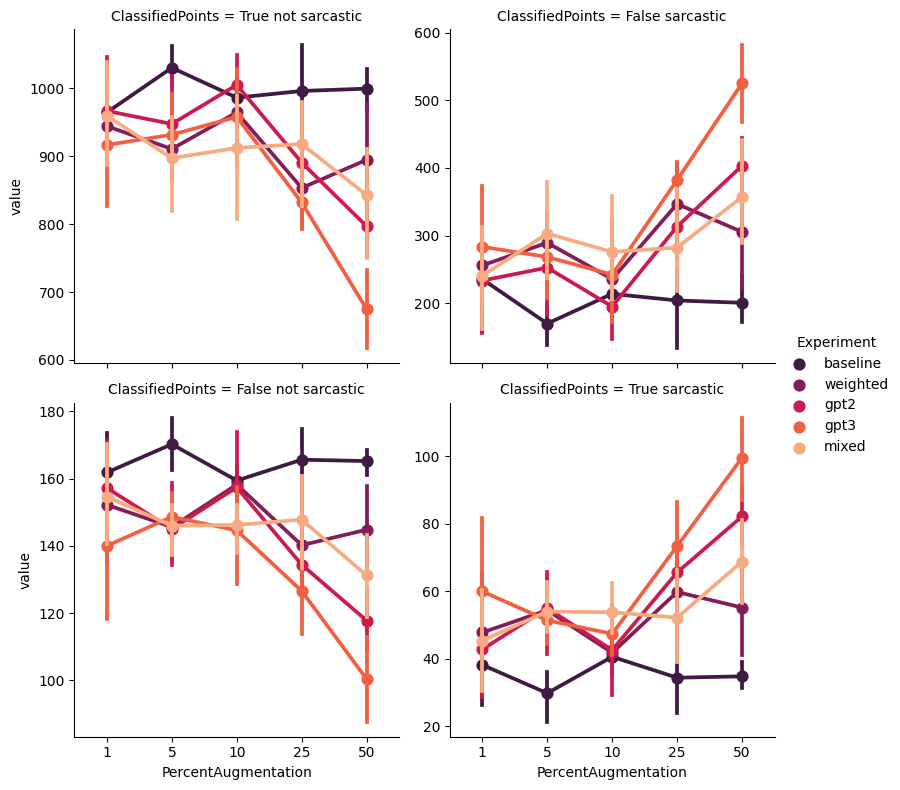

In [13]:
g = sns.catplot(
    data=cm_concatated, x="PercentAugmentation", y="value", hue="Experiment",
    col="ClassifiedPoints", kind="point", palette="rocket",
    height=4, aspect=1, col_wrap=2, sharey=False,
)

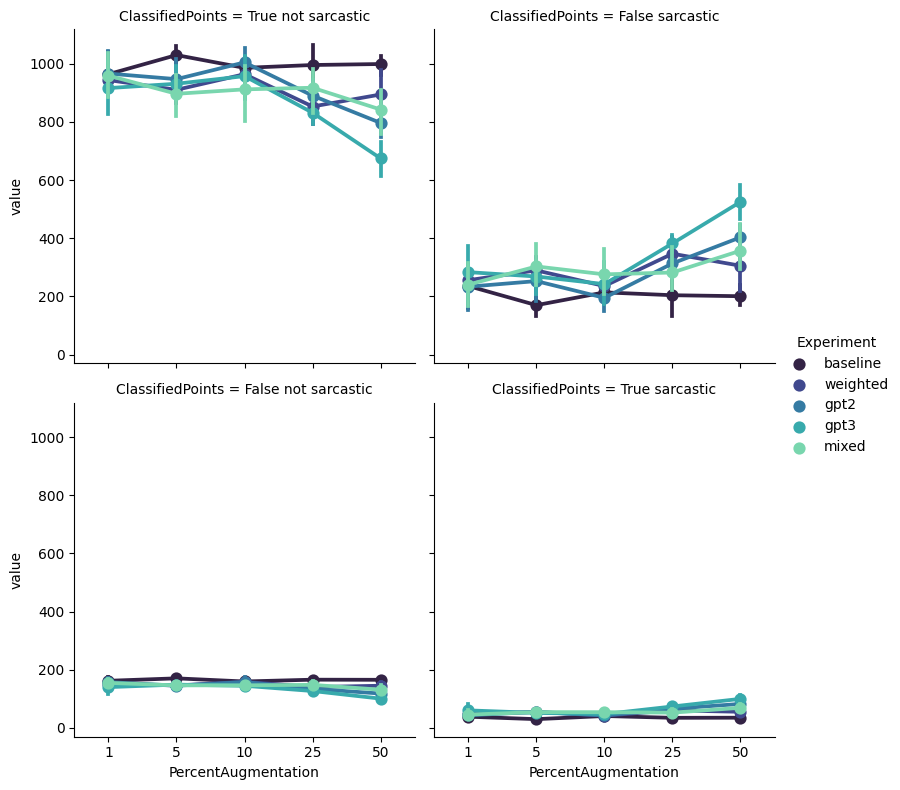

In [14]:
g = sns.catplot(
    data=cm_concatated, x="PercentAugmentation", y="value", hue="Experiment",
    col="ClassifiedPoints", kind="point", palette="mako",
    height=4, aspect=1, col_wrap=2
)

##F1- sarcastic

fetch and process data

In [15]:
baseline_f1_minor = baseline_df.loc[[8]]
weighted_baseline_f1_minor = weighted_baseline_df.loc[[8]]
augmented_gpt2_f1_minor = augmented_gpt2_df.loc[[8]]
augmented_gpt3_f1_minor = augmented_gpt3_df.loc[[8]]
augmented_gpt_mixed_f1_minor = augmented_gpt_mixed_df.loc[[8]]

concatenated_df_f1_minor= process_dataframes(
    baseline_f1_minor,
    weighted_baseline_f1_minor,
    augmented_gpt2_f1_minor,
    augmented_gpt3_f1_minor,
    augmented_gpt_mixed_f1_minor
    )



Plotting

<Axes: xlabel='PercentAugmentation', ylabel='value'>

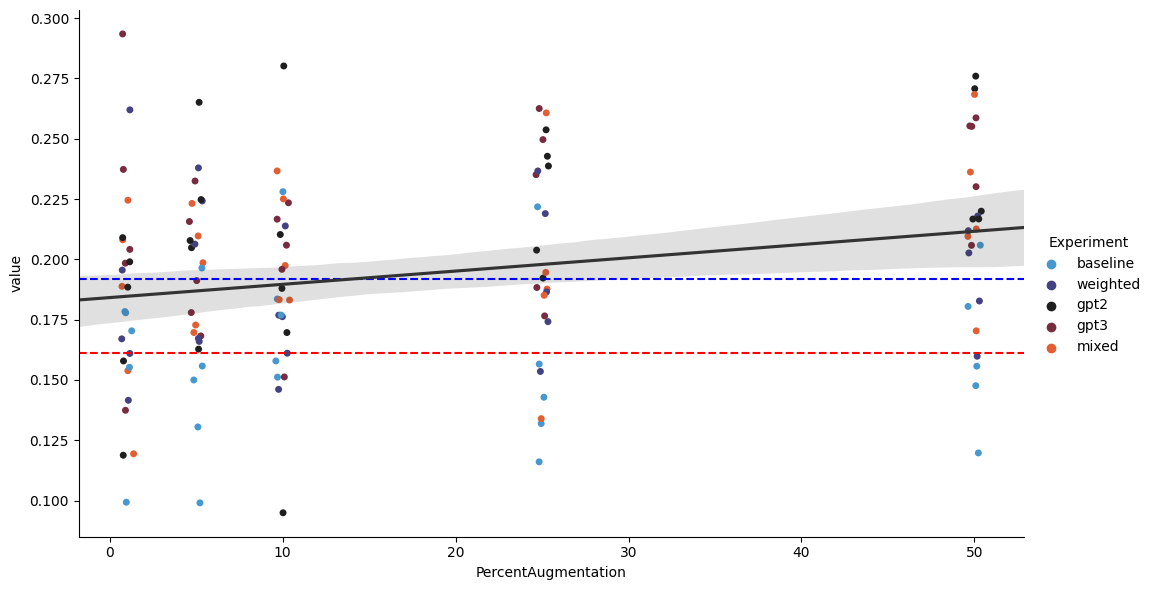

In [16]:
g = sns.catplot(
    data=concatenated_df_f1_minor, x="PercentAugmentation", y="value", hue="Experiment",
    palette="icefire",
    height=6, aspect=1.75,
    native_scale=True, zorder=1
)

plt.axhline(y=0.161176624, linestyle='--', color='red', label='Baseline')
plt.axhline(y=0.1918236694, linestyle='--', color='blue', label='Weighted Baseline')

sns.regplot(
    data=concatenated_df_f1_minor, x="PercentAugmentation", y="value",
    scatter=False, truncate=False, order=1, color=".2",
)

Plot by experiment

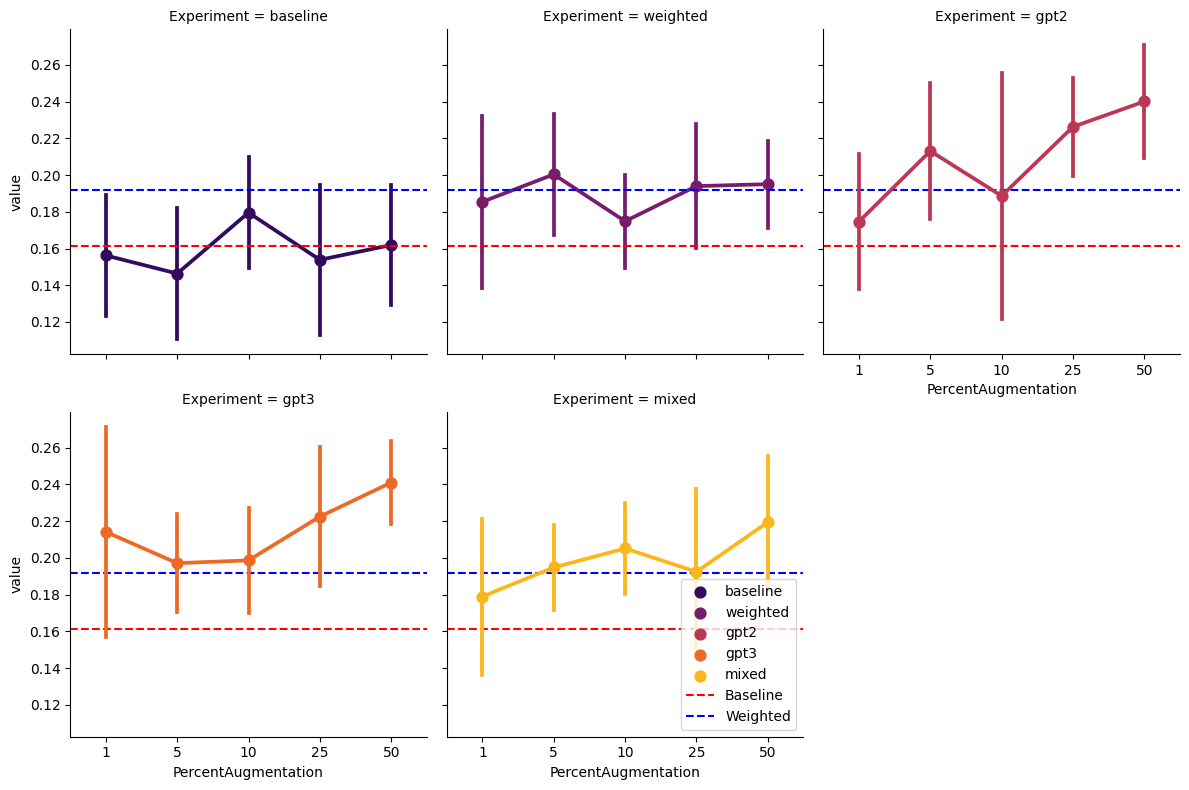

In [17]:
g = sns.catplot(
    data=concatenated_df_f1_minor, x="PercentAugmentation", y="value", hue="Experiment",
    col="Experiment", kind="point", palette="inferno",
    height=4, aspect=1, col_wrap=3, sharey=True, errorbar= "sd"
)
g.refline(y=0.161176624, linestyle='--', color='red', label='Baseline')
g.refline(y=0.1918236694, linestyle='--', color='blue', label='Weighted')
# Show the plot
plt.legend(loc="lower right")
plt.show()

Test for significant differences in F1-sarcastic score

In [18]:
percentages = [1, 5, 10, 25, 50]

for percentage in percentages:
    subset_data = concatenated_df_f1_minor[concatenated_df_f1_minor['PercentAugmentation'] == percentage]

    anova_result = f_oneway(
        subset_data[subset_data['Experiment'] == 'baseline']['value'],
        subset_data[subset_data['Experiment'] == 'gpt2']['value'],
        subset_data[subset_data['Experiment'] == 'gpt3']['value'],
        subset_data[subset_data['Experiment'] == 'mixed']['value'],
        subset_data[subset_data['Experiment'] == 'weighted']['value']
    )

    print(f"\nANOVA results for {percentage}% augmentation:")
    print("ANOVA p-value:", anova_result.pvalue)

    if anova_result.pvalue < 0.05:
        posthoc = pairwise_tukeyhsd(
            subset_data['value'],
            subset_data['Experiment'],
            alpha=0.05
        )

        print(posthoc)


ANOVA results for 1% augmentation:
ANOVA p-value: 0.366000890044737

ANOVA results for 5% augmentation:
ANOVA p-value: 0.03148265987097571
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
baseline     gpt2   0.0667 0.0237  0.0071 0.1263   True
baseline     gpt3   0.0508 0.1195 -0.0089 0.1104  False
baseline    mixed   0.0484 0.1478 -0.0112 0.1081  False
baseline weighted    0.054 0.0879 -0.0056 0.1136  False
    gpt2     gpt3  -0.0159 0.9274 -0.0756 0.0437  False
    gpt2    mixed  -0.0183  0.887 -0.0779 0.0414  False
    gpt2 weighted  -0.0127 0.9668 -0.0723 0.0469  False
    gpt3    mixed  -0.0023    1.0 -0.0619 0.0573  False
    gpt3 weighted   0.0032 0.9998 -0.0564 0.0628  False
   mixed weighted   0.0055 0.9986 -0.0541 0.0652  False
-------------------------------------------------------

ANOVA results for 10% augmentation:
ANOVA p-value: 0.7090867850101686

ANOV

Test if the different experiments differ from each other as a whole

In [19]:
all_data = concatenated_df_f1_minor.copy()

anova_result = f_oneway(
    all_data[all_data['Experiment'] == 'baseline']['value'],
    all_data[all_data['Experiment'] == 'gpt2']['value'],
    all_data[all_data['Experiment'] == 'gpt3']['value'],
    all_data[all_data['Experiment'] == 'mixed']['value'],
    all_data[all_data['Experiment'] == 'weighted']['value']
)

print("\nANOVA results for all experiments:")
print("ANOVA p-value:", anova_result.pvalue)

if anova_result.pvalue < 0.05:
    posthoc = pairwise_tukeyhsd(
        all_data['value'],
        all_data['Experiment'],
        alpha=0.05
    )

    print(posthoc)


ANOVA results for all experiments:
ANOVA p-value: 4.808202391741071e-06
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
baseline     gpt2   0.0489 0.0001  0.0199  0.078   True
baseline     gpt3   0.0551    0.0  0.0261 0.0841   True
baseline    mixed   0.0386 0.0032  0.0095 0.0676   True
baseline weighted   0.0303 0.0357  0.0013 0.0594   True
    gpt2     gpt3   0.0062 0.9768 -0.0229 0.0352  False
    gpt2    mixed  -0.0104 0.8591 -0.0394 0.0186  False
    gpt2 weighted  -0.0186  0.393 -0.0476 0.0104  False
    gpt3    mixed  -0.0165 0.5145 -0.0456 0.0125  False
    gpt3 weighted  -0.0247 0.1331 -0.0538 0.0043  False
   mixed weighted  -0.0082 0.9347 -0.0372 0.0208  False
-------------------------------------------------------


##F1 major

fetch

In [20]:
baseline_f1_major = baseline_df.loc[[7]]
weighted_baseline_f1_major = weighted_baseline_df.loc[[7]]
augmented_gpt2_f1_major = augmented_gpt2_df.loc[[7]]
augmented_gpt3_f1_major = augmented_gpt3_df.loc[[7]]
augmented_gpt_mixed_f1_major = augmented_gpt_mixed_df.loc[[7]]

process

In [21]:
concatenated_df_f1_major= process_dataframes(baseline_f1_major, weighted_baseline_f1_major, augmented_gpt2_f1_major, augmented_gpt3_f1_major, augmented_gpt_mixed_f1_major)

plot

<Axes: xlabel='PercentAugmentation', ylabel='value'>

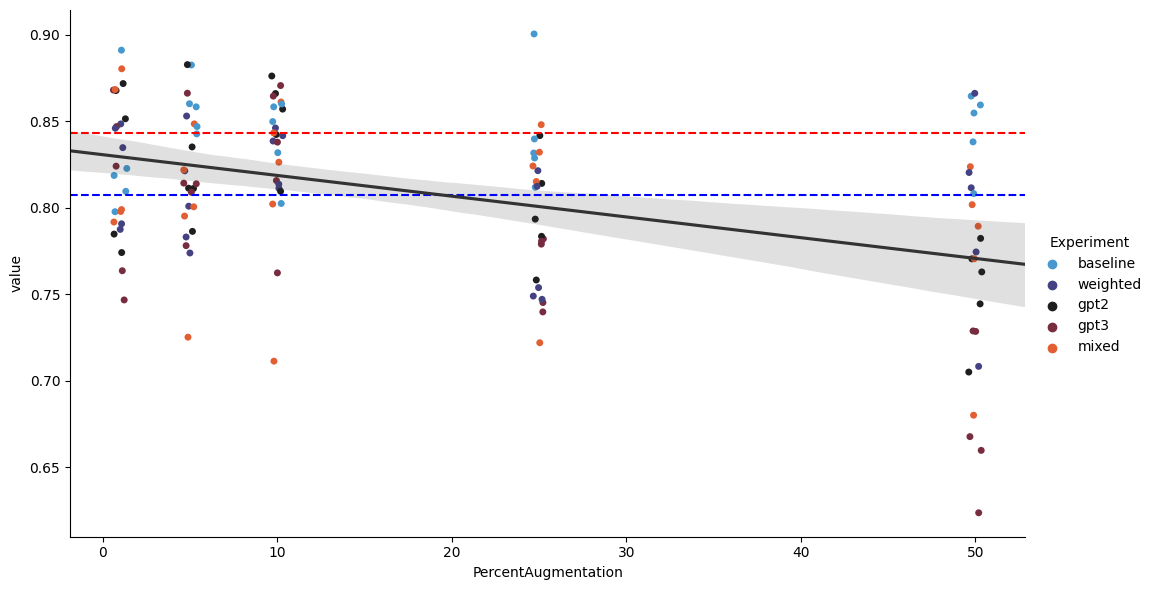

In [22]:
g = sns.catplot(
    data=concatenated_df_f1_major, x="PercentAugmentation", y="value", hue="Experiment",
    palette="icefire",
    height=6, aspect=1.75,
    native_scale=True, zorder=1
)
plt.axhline(y=0.8434422874, linestyle='--', color='red', label='Baseline')
plt.axhline(y=0.8073822931, linestyle='--', color='blue', label='Weighted Baseline')

sns.regplot(
    data=concatenated_df_f1_major, x="PercentAugmentation", y="value",
    scatter=False, truncate=False, order=1, color=".2",
)

Test for significant differences in F1- not sarcastic

In [23]:
for percentage in percentages:
    subset_data = concatenated_df_f1_major[concatenated_df_f1_major['PercentAugmentation'] == percentage]

    anova_result = f_oneway(
        subset_data[subset_data['Experiment'] == 'baseline']['value'],
        subset_data[subset_data['Experiment'] == 'gpt2']['value'],
        subset_data[subset_data['Experiment'] == 'gpt3']['value'],
        subset_data[subset_data['Experiment'] == 'mixed']['value'],
        subset_data[subset_data['Experiment'] == 'weighted']['value']
    )
    print(f"\nANOVA results for {percentage}% augmentation:")
    print("ANOVA p-value:", anova_result.pvalue)

    if anova_result.pvalue < 0.05:
        posthoc = pairwise_tukeyhsd(
            subset_data['value'],
            subset_data['Experiment'],
            alpha=0.05
        )

        print(posthoc)


ANOVA results for 1% augmentation:
ANOVA p-value: 0.9439888513096171

ANOVA results for 5% augmentation:
ANOVA p-value: 0.08804648307565843

ANOVA results for 10% augmentation:
ANOVA p-value: 0.5052423374981566

ANOVA results for 25% augmentation:
ANOVA p-value: 0.025162850922950154
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
baseline     gpt2  -0.0443 0.3226 -0.1122  0.0235  False
baseline     gpt3  -0.0772  0.021  -0.145 -0.0093   True
baseline    mixed  -0.0342 0.5686 -0.1021  0.0336  False
baseline weighted  -0.0658 0.0602 -0.1336  0.0021  False
    gpt2     gpt3  -0.0329 0.6046 -0.1007   0.035  False
    gpt2    mixed   0.0101 0.9912 -0.0577  0.0779  False
    gpt2 weighted  -0.0215 0.8752 -0.0893  0.0464  False
    gpt3    mixed    0.043 0.3515 -0.0249  0.1108  False
    gpt3 weighted   0.0114 0.9861 -0.0564  0.0793  False
   mixed weighted  -0.0316 0.63

##fscore-compare

In [24]:
tail_df_baseline_f1_compare = baseline_df.loc[[7,8]]
tail_df_weighted_baseline_f1_compare = weighted_baseline_df.loc[[7,8]]
tail_df_augmented_gpt2_f1_compare = augmented_gpt2_df.loc[[7,8]]
tail_df_augmented_gpt3_f1_compare = augmented_gpt3_df.loc[[7,8]]
tail_df_augmented_gpt_mixed_f1_compare = augmented_gpt_mixed_df.loc[[7,8]]

In [25]:
f1_both_concat = process_dataframes(tail_df_augmented_gpt2_f1_compare, tail_df_augmented_gpt3_f1_compare, tail_df_augmented_gpt_mixed_f1_compare)

In [26]:
experiment_info = f1_both_concat['Unnamed: 0'].str.extract(r'(?P<Experiment>\w+) F1-Score (?P<Class>\w+)$')
f1_both_concat['Class'] = experiment_info['Class']


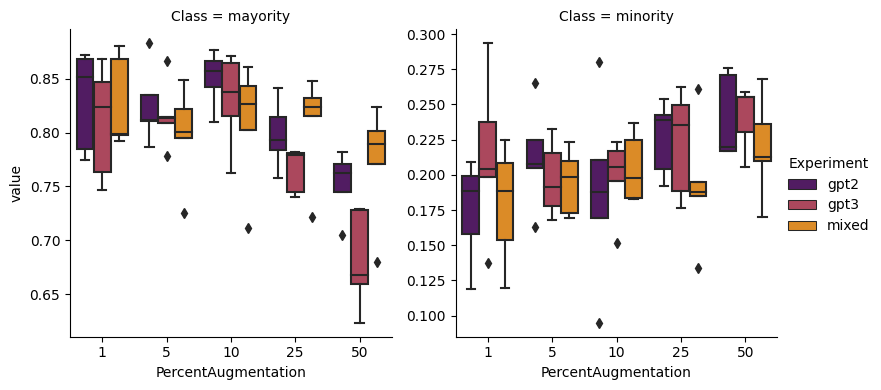

In [27]:
g = sns.catplot(
    data=f1_both_concat, x="PercentAugmentation", y="value", hue="Experiment",
    col="Class", kind="box", palette="inferno",
    height=4, aspect=1, col_wrap=2, sharey=False, errorbar= "sd"
)

##Accuracy

procedure: fetch-process-plot-test for significance

In [28]:
baseline_acc = baseline_df.loc[[0]]
weighted_baseline_acc = weighted_baseline_df.loc[[0]]
augmented_gpt2_f1_acc = augmented_gpt2_df.loc[[0]]
augmented_gpt3_f1_acc = augmented_gpt3_df.loc[[0]]
augmented_gpt_mixed_acc = augmented_gpt_mixed_df.loc[[0]]

In [29]:
concatenated_df_acc= process_dataframes(baseline_acc,weighted_baseline_acc, augmented_gpt2_f1_acc, augmented_gpt3_f1_acc,augmented_gpt_mixed_acc)

<Axes: xlabel='PercentAugmentation', ylabel='value'>

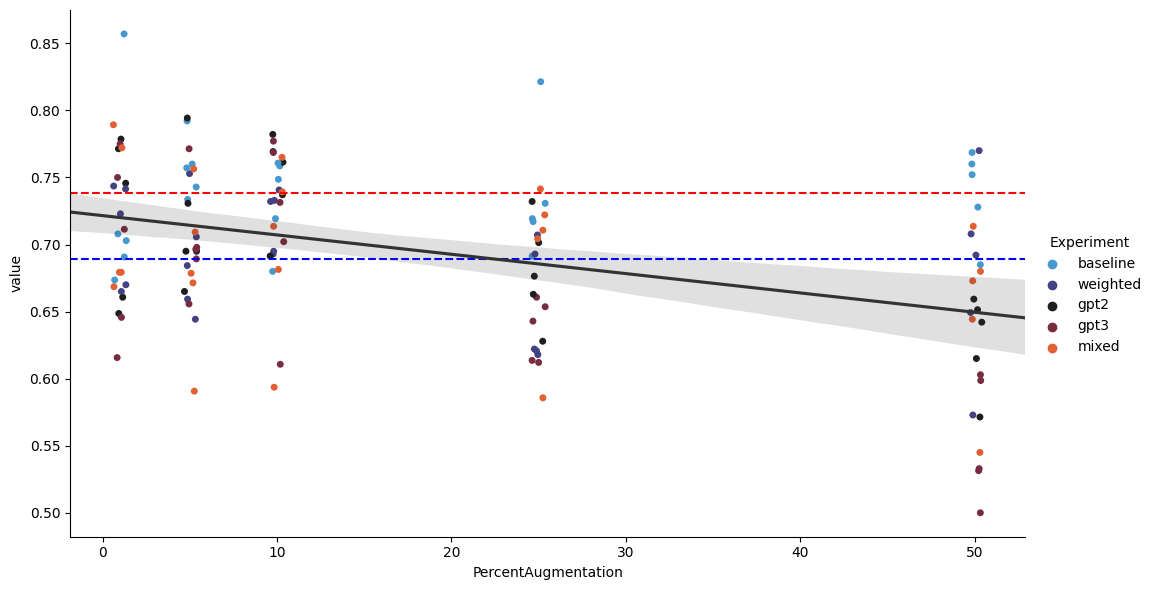

In [30]:
g = sns.catplot(
    data=concatenated_df_acc, x="PercentAugmentation", y="value", hue="Experiment",
    palette="icefire",
    height=6, aspect=1.75,
    native_scale=True, zorder=1
)
plt.axhline(y=0.73834, linestyle='--', color='red', label='Baseline')
plt.axhline(y=0.689436, linestyle='--', color='blue', label='Weighted Baseline')

sns.regplot(
    data=concatenated_df_acc, x="PercentAugmentation", y="value",
    scatter=False, truncate=False, order=1, color=".2",
)

In [31]:
for percentage in percentages:
    subset_data = concatenated_df_acc[concatenated_df_acc['PercentAugmentation'] == percentage]

    anova_result = f_oneway(
        subset_data[subset_data['Experiment'] == 'baseline']['value'],
        subset_data[subset_data['Experiment'] == 'gpt2']['value'],
        subset_data[subset_data['Experiment'] == 'gpt3']['value'],
        subset_data[subset_data['Experiment'] == 'mixed']['value'],
        subset_data[subset_data['Experiment'] == 'weighted']['value']
    )

    print(f"\nANOVA results for {percentage}% augmentation:")
    print("ANOVA p-value:", anova_result.pvalue)

    if anova_result.pvalue < 0.05:
        posthoc = pairwise_tukeyhsd(
            subset_data['value'],
            subset_data['Experiment'],
            alpha=0.05
        )

        print(posthoc)


ANOVA results for 1% augmentation:
ANOVA p-value: 0.9603917051853217

ANOVA results for 5% augmentation:
ANOVA p-value: 0.10857946780359257

ANOVA results for 10% augmentation:
ANOVA p-value: 0.5821449069488442

ANOVA results for 25% augmentation:
ANOVA p-value: 0.02224014508683235
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
baseline     gpt2  -0.0558 0.3256 -0.1416  0.0299  False
baseline     gpt3  -0.0994 0.0183 -0.1852 -0.0136   True
baseline    mixed  -0.0431  0.571 -0.1289  0.0426  False
baseline weighted  -0.0838 0.0573 -0.1696  0.0019  False
    gpt2     gpt3  -0.0436 0.5621 -0.1293  0.0422  False
    gpt2    mixed   0.0127 0.9914 -0.0731  0.0985  False
    gpt2 weighted   -0.028 0.8624 -0.1138  0.0578  False
    gpt3    mixed   0.0563 0.3186 -0.0295   0.142  False
    gpt3 weighted   0.0156 0.9816 -0.0702  0.1013  False
   mixed weighted  -0.0407 0.622

##AUC Score

procedure: fetch-process-plot-test for significance

In [32]:
baseline_auc = baseline_df.loc[[2]]
weighted_baseline_auc = weighted_baseline_df.loc[[2]]
augmented_gpt2_f1_auc = augmented_gpt2_df.loc[[2]]
augmented_gpt3_f1_auc = augmented_gpt3_df.loc[[2]]
augmented_gpt_mixed_auc = augmented_gpt_mixed_df.loc[[2]]

In [33]:
concatenated_df_auc= process_dataframes(baseline_auc,weighted_baseline_auc, augmented_gpt2_f1_auc, augmented_gpt3_f1_auc,augmented_gpt_mixed_auc)

<Axes: xlabel='PercentAugmentation', ylabel='value'>

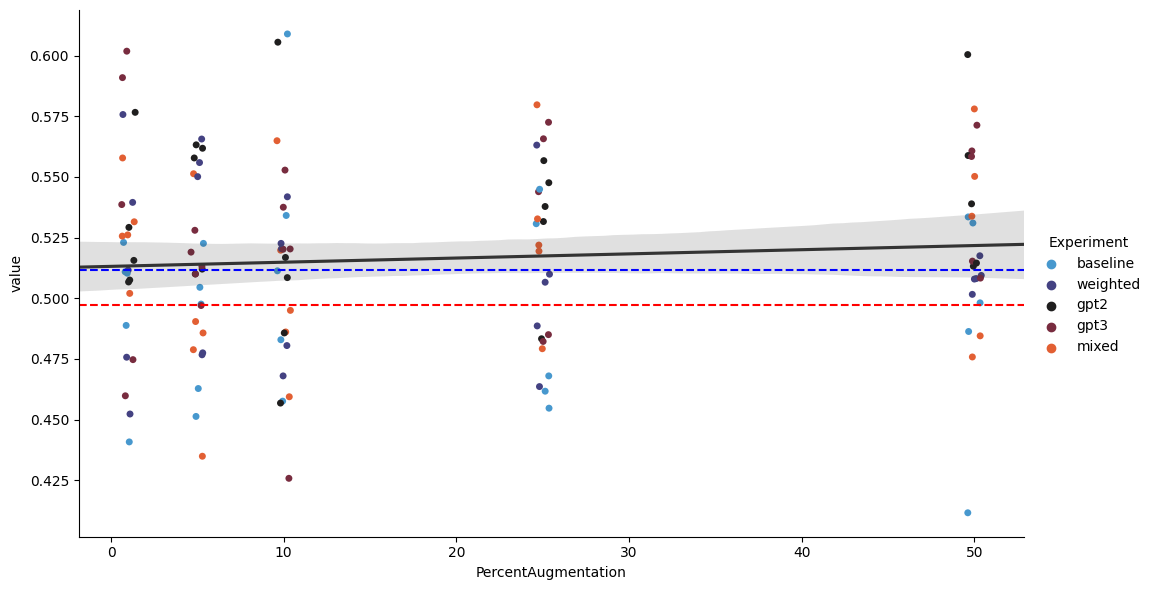

In [34]:
g = sns.catplot(
    data=concatenated_df_auc, x="PercentAugmentation", y="value", hue="Experiment",
    palette="icefire",
    height=6, aspect=1.75,
    native_scale=True, zorder=1
)

plt.axhline(y=0.497116, linestyle='--', color='red', label='Baseline')
plt.axhline(y=0.511608, linestyle='--', color='blue', label='Weighted Baseline')

sns.regplot(
    data=concatenated_df_auc, x="PercentAugmentation", y="value",
    scatter=False, truncate=False, order=1, color=".2",
)

In [35]:
for percentage in percentages:
    subset_data = concatenated_df_auc[concatenated_df_auc['PercentAugmentation'] == percentage]

    anova_result = f_oneway(
        subset_data[subset_data['Experiment'] == 'baseline']['value'],
        subset_data[subset_data['Experiment'] == 'gpt2']['value'],
        subset_data[subset_data['Experiment'] == 'gpt3']['value'],
        subset_data[subset_data['Experiment'] == 'mixed']['value'],
        subset_data[subset_data['Experiment'] == 'weighted']['value']
    )

    print(f"\nANOVA results for {percentage}% augmentation:")
    print("ANOVA p-value:", anova_result.pvalue)

    if anova_result.pvalue < 0.05:
        posthoc = pairwise_tukeyhsd(
            subset_data['value'],
            subset_data['Experiment'],
            alpha=0.05
        )

        print(posthoc)


ANOVA results for 1% augmentation:
ANOVA p-value: 0.5970510845260453

ANOVA results for 5% augmentation:
ANOVA p-value: 0.07704464770404483

ANOVA results for 10% augmentation:
ANOVA p-value: 0.9900824080892113

ANOVA results for 25% augmentation:
ANOVA p-value: 0.4056939679152544

ANOVA results for 50% augmentation:
ANOVA p-value: 0.14030368582834077


##Specificity

procedure: fetch-process-plot-test for significance

In [36]:
baseline_spec = baseline_df.loc[[6]]
weighted_baseline_spec = weighted_baseline_df.loc[[6]]
augmented_gpt2_f1_spec = augmented_gpt2_df.loc[[6]]
augmented_gpt3_f1_spec = augmented_gpt3_df.loc[[6]]
augmented_gpt_mixed_spec = augmented_gpt_mixed_df.loc[[6]]

In [37]:
concatenated_df_spec= process_dataframes(baseline_spec,weighted_baseline_spec, augmented_gpt2_f1_spec, augmented_gpt3_f1_spec,augmented_gpt_mixed_spec)

<Axes: xlabel='PercentAugmentation', ylabel='value'>

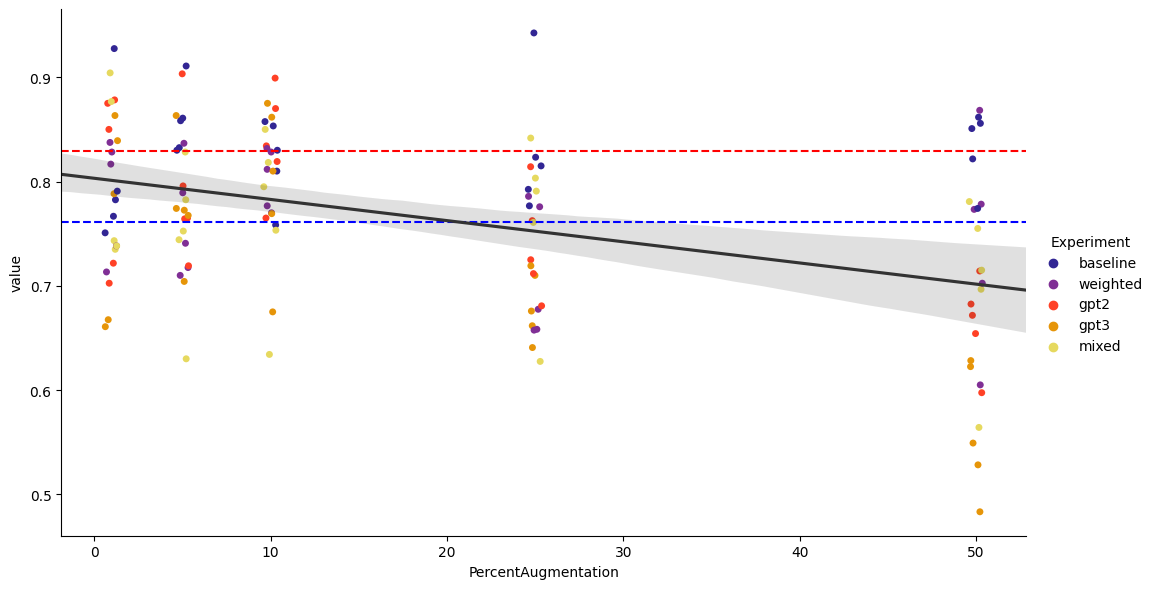

In [38]:
g = sns.catplot(
    data=concatenated_df_spec, x="PercentAugmentation", y="value", hue="Experiment",
    palette="CMRmap",
    height=6, aspect=1.75,
    native_scale=True, zorder=1
)

plt.axhline(y=0.82936, linestyle='--', color='red', label='Baseline')
plt.axhline(y=0.76116, linestyle='--', color='blue', label='Weighted Baseline')
sns.regplot(
    data=concatenated_df_spec, x="PercentAugmentation", y="value",
    scatter=False, truncate=False, order=1, color=".2",
)

In [39]:
for percentage in percentages:
    subset_data = concatenated_df_spec[concatenated_df_spec['PercentAugmentation'] == percentage]

    anova_result = f_oneway(
        subset_data[subset_data['Experiment'] == 'baseline']['value'],
        subset_data[subset_data['Experiment'] == 'gpt2']['value'],
        subset_data[subset_data['Experiment'] == 'gpt3']['value'],
        subset_data[subset_data['Experiment'] == 'mixed']['value'],
        subset_data[subset_data['Experiment'] == 'weighted']['value']
    )

    print(f"\nANOVA results for {percentage}% augmentation:")
    print("ANOVA p-value:", anova_result.pvalue)

    if anova_result.pvalue < 0.05:
        posthoc = pairwise_tukeyhsd(
            subset_data['value'],
            subset_data['Experiment'],
            alpha=0.05
        )

        print(posthoc)


ANOVA results for 1% augmentation:
ANOVA p-value: 0.9149727655109074

ANOVA results for 5% augmentation:
ANOVA p-value: 0.057749712932217916

ANOVA results for 10% augmentation:
ANOVA p-value: 0.4984099588053117

ANOVA results for 25% augmentation:
ANOVA p-value: 0.011886993474649362
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
baseline     gpt2  -0.0912 0.1718 -0.2075  0.0251  False
baseline     gpt3  -0.1485 0.0084 -0.2648 -0.0322   True
baseline    mixed  -0.0652 0.4692 -0.1815  0.0511  False
baseline weighted   -0.119 0.0433 -0.2353 -0.0027   True
    gpt2     gpt3  -0.0573  0.589 -0.1736   0.059  False
    gpt2    mixed    0.026 0.9609 -0.0903  0.1423  False
    gpt2 weighted  -0.0279 0.9501 -0.1442  0.0884  False
    gpt3    mixed   0.0833 0.2411  -0.033  0.1996  False
    gpt3 weighted   0.0295 0.9395 -0.0868  0.1458  False
   mixed weighted  -0.0538 0.6

##Loss

procedure: fetch-process-plot-test for significance

In [40]:
baseline_loss = baseline_df.loc[[1]]
weighted_baseline_loss = weighted_baseline_df.loc[[1]]
augmented_gpt2_f1_loss = augmented_gpt2_df.loc[[1]]
augmented_gpt3_f1_loss = augmented_gpt3_df.loc[[1]]
augmented_gpt_mixed_loss = augmented_gpt_mixed_df.loc[[1]]

In [41]:
concatenated_df_loss= process_dataframes(baseline_loss,weighted_baseline_loss, augmented_gpt2_f1_loss, augmented_gpt3_f1_loss,augmented_gpt_mixed_loss)

<Axes: xlabel='PercentAugmentation', ylabel='value'>

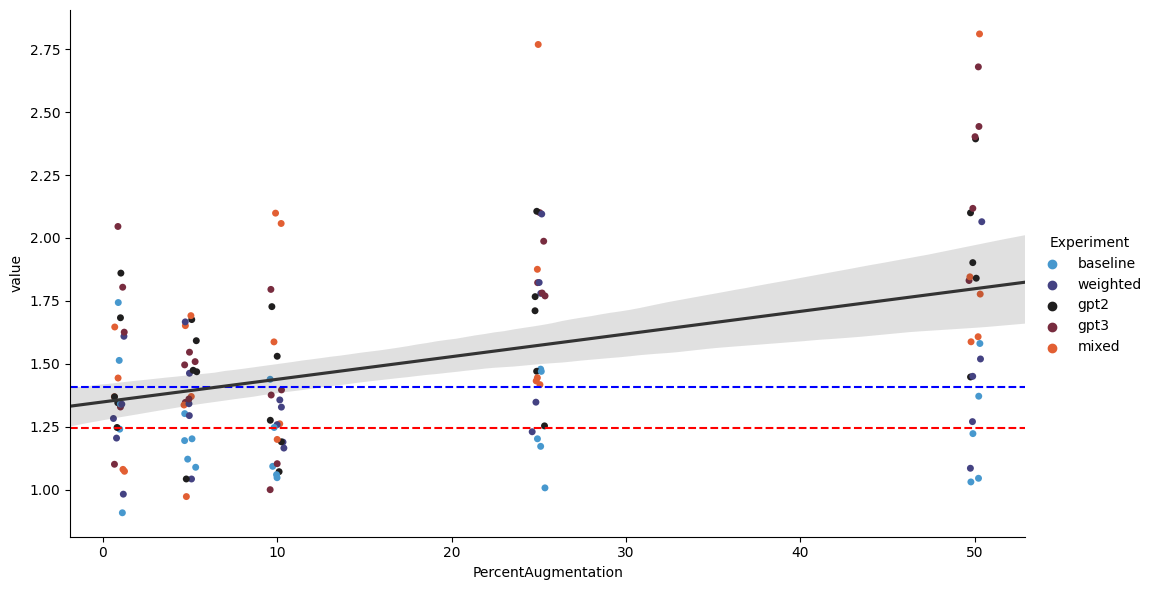

In [42]:
g = sns.catplot(
    data=concatenated_df_loss, x="PercentAugmentation", y="value", hue="Experiment",
    palette="icefire",
    height=6, aspect=1.75,
    native_scale=True, zorder=1
)

# Draw lines parallel to the x-axis for baseline versions
plt.axhline(y=1.24454, linestyle='--', color='red', label='Baseline')
plt.axhline(y=1.407256, linestyle='--', color='blue', label='Weighted Baseline')

sns.regplot(
    data=concatenated_df_loss, x="PercentAugmentation", y="value",
    scatter=False, truncate=False, order=1, color=".2",
)

In [43]:
for percentage in percentages:
    subset_data = concatenated_df_loss[concatenated_df_loss['PercentAugmentation'] == percentage]

    anova_result = f_oneway(
        subset_data[subset_data['Experiment'] == 'baseline']['value'],
        subset_data[subset_data['Experiment'] == 'gpt2']['value'],
        subset_data[subset_data['Experiment'] == 'gpt3']['value'],
        subset_data[subset_data['Experiment'] == 'mixed']['value'],
        subset_data[subset_data['Experiment'] == 'weighted']['value']
    )

    print(f"\nANOVA results for {percentage}% augmentation:")
    print("ANOVA p-value:", anova_result.pvalue)

    if anova_result.pvalue < 0.05:
        posthoc = pairwise_tukeyhsd(
            subset_data['value'],
            subset_data['Experiment'],
            alpha=0.05
        )

        print(posthoc)


ANOVA results for 1% augmentation:
ANOVA p-value: 0.4454935745512999

ANOVA results for 5% augmentation:
ANOVA p-value: 0.24769806596393965

ANOVA results for 10% augmentation:
ANOVA p-value: 0.1319185600677313

ANOVA results for 25% augmentation:
ANOVA p-value: 0.10271461673991081

ANOVA results for 50% augmentation:
ANOVA p-value: 0.0018552458582556841
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
baseline     gpt2   0.6868  0.054 -0.0087  1.3823  False
baseline     gpt3    1.045 0.0018  0.3495  1.7405   True
baseline    mixed   0.6758 0.0594 -0.0197  1.3713  False
baseline weighted   0.2279 0.8609 -0.4676  0.9234  False
    gpt2     gpt3   0.3582 0.5493 -0.3373  1.0537  False
    gpt2    mixed   -0.011    1.0 -0.7065  0.6845  False
    gpt2 weighted  -0.4589 0.3133 -1.1544  0.2366  False
    gpt3    mixed  -0.3692 0.5211 -1.0647  0.3263  False
    gpt3 weight

##Weighted F1 score

procedure: fetch-process-plot-test for significance

In [44]:
baseline_fmicro = baseline_df.loc[[5]]
weighted_baseline_fmicro = weighted_baseline_df.loc[[5]]
augmented_gpt2_fmicro = augmented_gpt2_df.loc[[5]]
augmented_gpt3_fmicro = augmented_gpt3_df.loc[[5]]
augmented_gpt_mixed_fmicro = augmented_gpt_mixed_df.loc[[5]]

In [45]:
concatenated_df_fmicro= process_dataframes(baseline_fmicro,weighted_baseline_fmicro, augmented_gpt2_fmicro, augmented_gpt3_fmicro,augmented_gpt_mixed_fmicro)

<Axes: xlabel='PercentAugmentation', ylabel='value'>

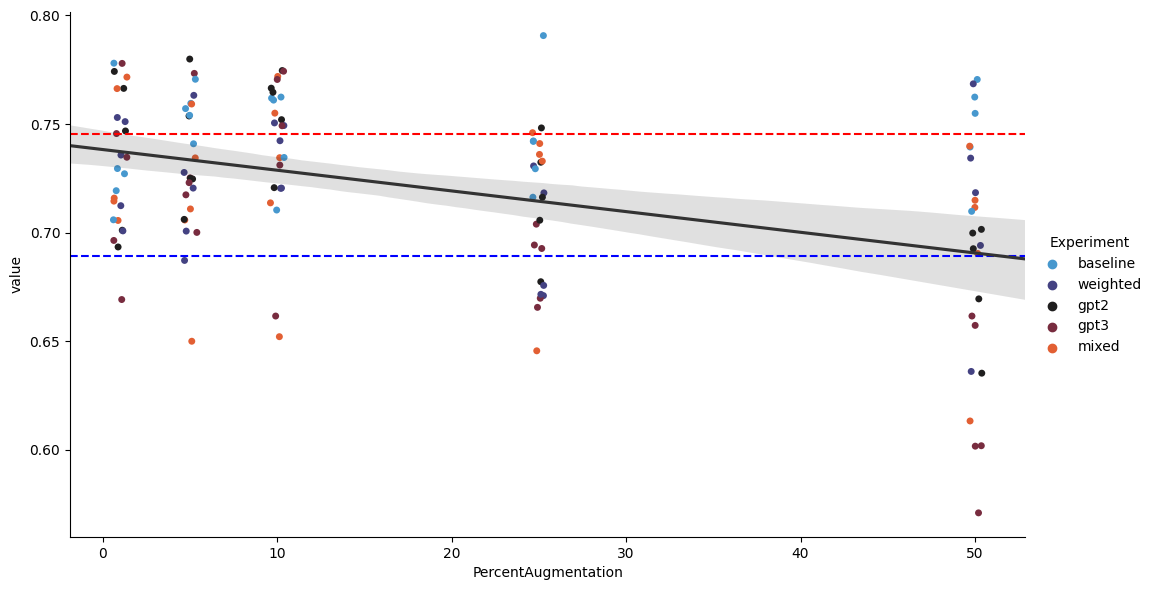

In [46]:
g = sns.catplot(
    data=concatenated_df_fmicro, x="PercentAugmentation", y="value", hue="Experiment",
    palette="icefire",
    height=6, aspect=1.75,
    native_scale=True, zorder=1
)
plt.axhline(y=0.745192, linestyle='--', color='red', label='Baseline')
plt.axhline(y=0.689436, linestyle='--', color='blue', label='Weighted Baseline')

sns.regplot(
    data=concatenated_df_fmicro, x="PercentAugmentation", y="value",
    scatter=False, truncate=False, order=1, color=".2",
)

In [47]:
for percentage in percentages:
    subset_data = concatenated_df_fmicro[concatenated_df_fmicro['PercentAugmentation'] == percentage]

    anova_result = f_oneway(
        subset_data[subset_data['Experiment'] == 'baseline']['value'],
        subset_data[subset_data['Experiment'] == 'gpt2']['value'],
        subset_data[subset_data['Experiment'] == 'gpt3']['value'],
        subset_data[subset_data['Experiment'] == 'mixed']['value'],
        subset_data[subset_data['Experiment'] == 'weighted']['value']
    )

    print(f"\nANOVA results for {percentage}% augmentation:")
    print("ANOVA p-value:", anova_result.pvalue)

    if anova_result.pvalue < 0.05:
        posthoc = pairwise_tukeyhsd(
            subset_data['value'],
            subset_data['Experiment'],
            alpha=0.05
        )

        print(posthoc)


ANOVA results for 1% augmentation:
ANOVA p-value: 0.9838083495835777

ANOVA results for 5% augmentation:
ANOVA p-value: 0.17515842235146156

ANOVA results for 10% augmentation:
ANOVA p-value: 0.6759700829839497

ANOVA results for 25% augmentation:
ANOVA p-value: 0.03888107087510556
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
baseline     gpt2  -0.0281 0.5738 -0.0842   0.028  False
baseline     gpt3  -0.0589 0.0367 -0.1149 -0.0028   True
baseline    mixed  -0.0238  0.711 -0.0799  0.0323  False
baseline weighted  -0.0507 0.0889 -0.1067  0.0054  False
    gpt2     gpt3  -0.0307 0.4904 -0.0868  0.0253  False
    gpt2    mixed   0.0043 0.9993 -0.0518  0.0604  False
    gpt2 weighted  -0.0225 0.7498 -0.0786  0.0335  False
    gpt3    mixed    0.035 0.3643  -0.021  0.0911  False
    gpt3 weighted   0.0082 0.9918 -0.0479  0.0643  False
   mixed weighted  -0.0268 0.615

##Precision

procedure: fetch-process-plot-test for significance

In [48]:
baseline_prec = baseline_df.loc[[3]]
weighted_baseline_prec = weighted_baseline_df.loc[[3]]
augmented_gpt2_prec = augmented_gpt2_df.loc[[3]]
augmented_gpt3_prec = augmented_gpt3_df.loc[[3]]
augmented_gpt_mixed_prec = augmented_gpt_mixed_df.loc[[3]]

In [49]:
concatenated_df_prec= process_dataframes(baseline_prec,weighted_baseline_prec, augmented_gpt2_prec, augmented_gpt3_prec,augmented_gpt_mixed_prec)

<Axes: xlabel='PercentAugmentation', ylabel='value'>

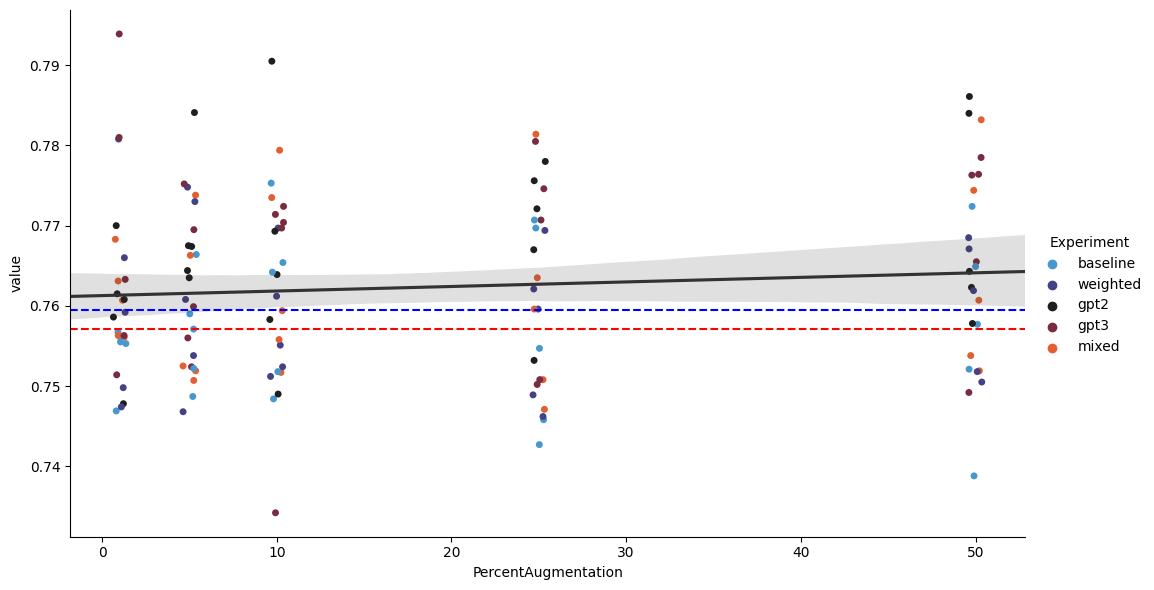

In [50]:
g = sns.catplot(
    data=concatenated_df_prec, x="PercentAugmentation", y="value", hue="Experiment",
    palette="icefire",
    height=6, aspect=1.75,
    native_scale=True, zorder=1
)

plt.axhline(y=0.757136, linestyle='--', color='red', label='Baseline')
plt.axhline(y=0.75952, linestyle='--', color='blue', label='Weighted Baseline')

sns.regplot(
    data=concatenated_df_prec, x="PercentAugmentation", y="value",
    scatter=False, truncate=False, order=1, color=".2",
)

In [51]:
for percentage in percentages:
    subset_data = concatenated_df_prec[concatenated_df_prec['PercentAugmentation'] == percentage]

    anova_result = f_oneway(
        subset_data[subset_data['Experiment'] == 'baseline']['value'],
        subset_data[subset_data['Experiment'] == 'gpt2']['value'],
        subset_data[subset_data['Experiment'] == 'gpt3']['value'],
        subset_data[subset_data['Experiment'] == 'mixed']['value'],
        subset_data[subset_data['Experiment'] == 'weighted']['value']
    )

    print(f"\nANOVA results for {percentage}% augmentation:")
    print("ANOVA p-value:", anova_result.pvalue)

    if anova_result.pvalue < 0.05:
        posthoc = pairwise_tukeyhsd(
            subset_data['value'],
            subset_data['Experiment'],
            alpha=0.05
        )

        print(posthoc)


ANOVA results for 1% augmentation:
ANOVA p-value: 0.34026671258509633

ANOVA results for 5% augmentation:
ANOVA p-value: 0.3245425508711112

ANOVA results for 10% augmentation:
ANOVA p-value: 0.872966503771762

ANOVA results for 25% augmentation:
ANOVA p-value: 0.44051985763058277

ANOVA results for 50% augmentation:
ANOVA p-value: 0.3600705130468523


#Survey data

## agreement on sarcasm overall

count labels

This code was created by ChatGPT

In [52]:
# Create a mapping dictionary for 'Ground Truth' column
ground_truth_mapping = {'sarcastic': 1, 'not sarcastic': 0}
df_sarcasm['Ground Truth'] = df_sarcasm['Ground Truth'].map(ground_truth_mapping)

# Assuming 'Ground Truth' column contains the true labels (0 or 1) for sarcasm
ground_truth_sarcasm = df_sarcasm['Ground Truth'].values

# Assuming Annotator 1 to Annotator 5 are columns in the DataFrame
annotators_columns = ['Annotator 1', 'Annotator 2', 'Annotator 3', 'Annotator 4', 'Annotator 5']
for col in annotators_columns:
    df_sarcasm[col] = df_sarcasm[col].map(ground_truth_mapping)

# Assuming Annotator 1 to Annotator 5 are columns in the DataFrame
ratings_sarcasm = df_sarcasm[annotators_columns].values


In [53]:
df_sarcasm['Count_Label_0'] = df_sarcasm[['Annotator 1', 'Annotator 2', 'Annotator 3', 'Annotator 4', 'Annotator 5']].eq(1).sum(axis=1)
df_sarcasm['Count_Label_1'] = df_sarcasm[['Annotator 1', 'Annotator 2', 'Annotator 3', 'Annotator 4', 'Annotator 5']].eq(0).sum(axis=1)

df_sorted_label_0 = df_sarcasm.sort_values(by='Count_Label_0', ascending=False).head(10)
df_sorted_label_1 = df_sarcasm.sort_values(by='Count_Label_1', ascending=False).head(10)

fleiss

In [54]:
categories = ['Annotator 1', 'Annotator 2', 'Annotator 3', 'Annotator 4', 'Annotator 5']
M_sarcasm = df_sarcasm[categories].values

# Calculate Fleiss' Kappa using kappam_fleiss
result_fleiss_kappa = kappam_fleiss(M_sarcasm, detail=True)

# Print the result
print(result_fleiss_kappa)

            Fleiss` Kappa for m Raters            
Subjects = 40
  Raters = 5
   Kappa = 0.212

       z = 4.242
 p-value = 0.000

   Kappa      z  p.value
0  0.212  4.242      0.0
1  0.212  4.242      0.0



#machine

Extract the origin

In [55]:
import pandas as pd

def extract_origin(label):
    if label == 'manual':
        return 'manual'
    elif label.startswith('generated'):
        return label[-1]
    else:
        return None

df_machine['Origin'] = df_machine['Ground Truth'].apply(extract_origin)
df_machine['Ground Truth'] = df_machine['Ground Truth'].replace(r'\d', '', regex=True)

In [56]:
ground_truth_mapping = {'manual': 'generated by human', 'generated': 'generated by language model'}

df_machine['Ground Truth'] = df_machine['Ground Truth'].map(ground_truth_mapping)

agreement on generated by lm or not

In [57]:
M_machine = df_machine[categories].values

# Calculate Fleiss' Kappa using kappam_fleiss
result_fleiss_kappa = kappam_fleiss(M_machine, detail=True)

# Print the result
print(result_fleiss_kappa)

            Fleiss` Kappa for m Raters            
Subjects = 40
  Raters = 5
   Kappa = 0.140

       z = 2.801
 p-value = 0.005

                             Kappa      z  p.value
generated by human            0.14  2.801    0.005
generated by language model   0.14  2.801    0.005



count labels

In [58]:
df_machine

,Ground Truth,Tweet Number,TEXT,Annotator 1,Annotator 2,Annotator 3,Annotator 4,Annotator 5,Origin
0,generated by human,Tweet 1,@AvatarOdin @aubviouslynot sounds like the ame...,generated by human,generated by human,generated by human,generated by human,generated by human,manual
1,generated by human,Tweet 2,the hurricane has been completely underwhelming,generated by language model,generated by language model,generated by language model,generated by language model,generated by human,manual
2,generated by human,Tweet 3,My new favorite thing to do while teaching thi...,generated by human,generated by language model,generated by human,generated by human,generated by human,manual
3,generated by human,Tweet 4,Between Mikey cooking and Didi cooking for me ...,generated by human,generated by human,generated by language model,generated by language model,generated by language model,manual
4,generated by human,Tweet 5,“The App Store [is]... an economic miracle” 🙄 ...,generated by language model,generated by human,generated by language model,generated by human,generated by human,manual
5,generated by language model,Tweet 6,love being able to have someone change my clot...,generated by human,generated by human,generated by human,generated by human,generated by language model,1
6,generated by human,Tweet 7,#whitepeoplelovesaying “They must not want me ...,generated by human,generated by language model,generated by human,generated by human,generated by language model,manual
7,generated by human,Tweet 8,i hate when that guy on tiktok is all “i uNdeR...,generated by human,generated by human,generated by human,generated by human,generated by human,manual
8,generated by language model,Tweet 9,it’s amazing how many people ask me about the ...,generated by human,generated by language model,generated by human,generated by language model,generated by language model,1
9,generated by human,Tweet 10,Thank you to my apartment complex for consiste...,generated by human,generated by human,generated by human,generated by human,generated by human,manual


In [59]:
df_machine['Count_Human'] = df_machine[['Annotator 1', 'Annotator 2', 'Annotator 3', 'Annotator 4', 'Annotator 5']].eq("generated by human").sum(axis=1)
df_machine['Count_Model'] = df_machine[['Annotator 1', 'Annotator 2', 'Annotator 3', 'Annotator 4', 'Annotator 5']].eq("generated by language model").sum(axis=1)


In [60]:
df_sorted_machine = df_machine.sort_values(by='Count_Model', ascending=False).head(10)
df_sorted_human = df_machine.sort_values(by='Count_Human', ascending=False).head(10)

In [61]:
df_generated_rows = df_machine[df_machine['Ground Truth'].isin(['generated by language model'])]

In [62]:
df_generated_rows = df_generated_rows.reset_index(drop=True)

difference in origin of model regarfing machine

In [63]:
contingency_table = pd.crosstab(df_generated_rows['Origin'], df_generated_rows['Count_Model'])

# Perform the chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Display the results
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

# Interpret the results
alpha = 0.05  # significance level
print(f"Significance level: {alpha}")
if p < alpha:
    print("Reject the null hypothesis: There is a significant difference between Origin values.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between Origin values.")

Chi-squared value: 2.333333333333333
P-value: 0.5061652190939085
Significance level: 0.05
Fail to reject the null hypothesis: There is no significant difference between Origin values.


chi sq

In [64]:
model_A = df_generated_rows[df_generated_rows['Origin'] == "1"]
model_B = df_generated_rows[df_generated_rows['Origin'] == "2"]

In [65]:
# Detailed t-test
t_stat, p_value = ttest_ind(model_A['Count_Model'], model_B['Count_Model'])

print("Detailed t-test:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

Detailed t-test:
T-statistic: 1.234426799696735
P-value: 0.252072


probab of identifying model

Code below was generated by ChatGPT

In [66]:
# Probability of correct identification
prob_correct_A = model_A['Count_Model'].mean() / 5
prob_correct_B = model_B['Count_Model'].mean() / 5

# Difference between the two systems
difference = prob_correct_A - prob_correct_B

# Display results
print("Probability of correct identification for Model A:", prob_correct_A)
print("Probability of correct identification for Model B:", prob_correct_B)
print("Difference between the two systems:", difference)


Probability of correct identification for Model A: 0.27999999999999997
Probability of correct identification for Model B: 0.12
Difference between the two systems: 0.15999999999999998


agreement machine GPT2

In [67]:
M_model_A = model_A[categories].values

# Calculate Fleiss' Kappa using kappam_fleiss
result_fleiss_kappa = kappam_fleiss(M_model_A, detail=True)

# Print the result
print(result_fleiss_kappa)

            Fleiss` Kappa for m Raters            
Subjects = 5
  Raters = 5
   Kappa = 0.008

       z = 0.056
 p-value = 0.955

                             Kappa      z  p.value
generated by human           0.008  0.056    0.955
generated by language model  0.008  0.056    0.955



agreement machine GPT3

In [68]:
M_model_B = model_B[categories].values

# Calculate Fleiss' Kappa using kappam_fleiss
result_fleiss_kappa = kappam_fleiss(M_model_B, detail=True)

# Print the result
print(result_fleiss_kappa)

            Fleiss` Kappa for m Raters            
Subjects = 5
  Raters = 5
   Kappa = 0.053

       z = 0.375
 p-value = 0.708

                             Kappa      z  p.value
generated by human           0.053  0.375    0.708
generated by language model  0.053  0.375    0.708



##agrrement on sarcasm generated by machine

Process data

In [69]:
df_sarcasm["origin"] =  df_machine["Origin"]

In [70]:
df_sarcasm['Count_sarcastic'] = df_sarcasm[['Annotator 1', 'Annotator 2', 'Annotator 3', 'Annotator 4', 'Annotator 5']].eq(1).sum(axis=1)
df_sarcasm['Count_not_sarcastic'] = df_sarcasm[['Annotator 1', 'Annotator 2', 'Annotator 3', 'Annotator 4', 'Annotator 5']].eq(0).sum(axis=1)

In [71]:
model_A_sarcasm = df_sarcasm[df_sarcasm['origin'] == "1"]
model_B_sarcasm = df_sarcasm[df_sarcasm['origin'] == "2"]
generated_sarcasm = pd.concat([model_A_sarcasm, model_B_sarcasm], ignore_index=True)

In [72]:
df_sorted_machine = df_machine.sort_values(by='Count_Model', ascending=False).head(10)
df_sorted_human = df_machine.sort_values(by='Count_Human', ascending=False).head(10)

Probab to rightfully detect sarcasm in generated

In [73]:
# Probability of correct identification
prob_correct_A_s = model_A_sarcasm['Count_sarcastic'].mean() / 5
prob_correct_B_s = model_B_sarcasm['Count_sarcastic'].mean() / 5

# Difference between the two systems
difference = prob_correct_A_s - prob_correct_B_s

# Display results
print("Probability of correct identification for Model A:", prob_correct_A_s)
print("Probability of correct identification for Model B:", prob_correct_B_s)
print("Difference between the two systems:", difference)

Probability of correct identification for Model A: 0.44000000000000006
Probability of correct identification for Model B: 0.5599999999999999
Difference between the two systems: -0.11999999999999988


agreement on gpt2 sarcasm

In [74]:
M_model_A_sarcasm = model_A_sarcasm[categories].values

# Calculate Fleiss' Kappa using kappam_fleiss
result_fleiss_kappa = kappam_fleiss(M_model_A_sarcasm, detail=True)
# Print the result
print(result_fleiss_kappa)

            Fleiss` Kappa for m Raters            
Subjects = 5
  Raters = 5
   Kappa = -0.136

       z = -0.964
 p-value = 0.335

   Kappa      z  p.value
0 -0.136 -0.964    0.335
1 -0.136 -0.964    0.335



agreement on gpt3 sarcasm

In [75]:
M_model_B_sarcasm = model_B_sarcasm[categories].values
# Calculate Fleiss' Kappa using kappam_fleiss
result_fleiss_kappa = kappam_fleiss(M_model_B_sarcasm, detail=True)
print(result_fleiss_kappa)

            Fleiss` Kappa for m Raters            
Subjects = 5
  Raters = 5
   Kappa = -0.136

       z = -0.964
 p-value = 0.335

   Kappa      z  p.value
0 -0.136 -0.964    0.335
1 -0.136 -0.964    0.335



agreement on sarcasm by machine

In [76]:
generated_sarcasm = pd.concat([model_A_sarcasm, model_B_sarcasm], ignore_index=True)

In [77]:
M_generated_sarcasm = generated_sarcasm[categories].values
# Calculate Fleiss' Kappa using kappam_fleiss
result_fleiss_kappa = kappam_fleiss(M_generated_sarcasm, detail=True)
print(result_fleiss_kappa)

            Fleiss` Kappa for m Raters            
Subjects = 10
  Raters = 5
   Kappa = -0.120

       z = -1.200
 p-value = 0.230

   Kappa    z  p.value
0  -0.12 -1.2     0.23
1  -0.12 -1.2     0.23



agreement on manual sarcasm

In [78]:
manual_sarcasm = df_sarcasm[df_sarcasm['origin'] == "manual"]

In [79]:
M_manual_sarcasm = manual_sarcasm[categories].values
# Calculate Fleiss' Kappa using kappam_fleiss
result_fleiss_kappa = kappam_fleiss(M_manual_sarcasm, detail=True)
print(result_fleiss_kappa)

            Fleiss` Kappa for m Raters            
Subjects = 30
  Raters = 5
   Kappa = 0.321

       z = 5.565
 p-value = 0.000

   Kappa      z  p.value
0  0.321  5.565      0.0
1  0.321  5.565      0.0



agreemen on human sarcasm

In [80]:
manual_sarcasm_only_sarcastic = manual_sarcasm[manual_sarcasm['Ground Truth'] == 1]
M_manual_sarcasm_only_sarcastic = manual_sarcasm_only_sarcastic[categories].values
# Calculate Fleiss' Kappa using kappam_fleiss
result_fleiss_kappa = kappam_fleiss(M_manual_sarcasm_only_sarcastic, detail=True)
print(result_fleiss_kappa)

            Fleiss` Kappa for m Raters            
Subjects = 10
  Raters = 5
   Kappa = 0.439

       z = 4.391
 p-value = 0.000

   Kappa      z  p.value
0  0.439  4.391      0.0
1  0.439  4.391      0.0



agrement on human unsarcastic

In [81]:
manual_sarcasm_only_nosarc = manual_sarcasm[manual_sarcasm['Ground Truth'] == 0]
M_manual_sarcasm_only_nosarc = manual_sarcasm_only_nosarc[categories].values
# Calculate Fleiss' Kappa using kappam_fleiss
result_fleiss_kappa = kappam_fleiss(M_manual_sarcasm_only_nosarc, detail=True)
print(result_fleiss_kappa)

            Fleiss` Kappa for m Raters            
Subjects = 20
  Raters = 5
   Kappa = 0.243

       z = 3.442
 p-value = 0.001

   Kappa      z  p.value
0  0.243  3.442    0.001
1  0.243  3.442    0.001

